In [52]:
# Solving the "gravitational settling in two dimensions" problem in Lautrup p. 182
import numpy as np
import matplotlib.pyplot as plt
from fenics import * 

# Physical constants 
g0     = 9.8
rho    = 917
rhow   = 1029
E, nu  = 2.5e9, 0.3

mu  = E/(2+2*nu)
lam = E*nu/((1+nu)*(1-2*nu))

def tau(u): return sig(u)+tr(sig(u))/2* Identity (2)


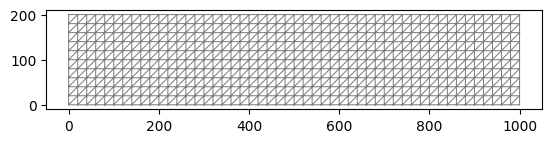

In [2]:
# The 2D mesh
W, H = 1e3, 0.2e3  # Length, Height (m)
Hres = 10
Wres = 10*5
mesh = RectangleMesh(Point(0,0), Point(W,H), Wres, Hres)

plt.figure()
plot(mesh, lw=0.75); 

In [3]:
# Function space
deg = 1 # Polynomial degree 
V   = VectorFunctionSpace(mesh, 'Lagrange', deg); # Polynomial function space of order "deg" (=1 is linear, ...)
u   = TrialFunction(V) # the unknown function
w   = TestFunction(V)  # the weight function 

# The FEM problem
fvec = rho*Constant((0,-g0)) # Gravity force vector
def eps(u): return sym(grad(u)) # strain tensor (symmetric gradient of displacement field, i.e. 2x2 matrix)
def sig(u): return 2*mu*eps(u) + lam*Identity(2)*tr(eps(u))
a = inner(sig(u), grad(w)) * dx # "inner" is the double dot product
L = dot(fvec,w) * dx            # "dot" is the regular (single) dot product 
# Note no boundary terms! w_i=0 where u_i is specified, and we assume no shear stresses which removes the remaining contributions (see slides).

# Define the 4 boundaries
# Note "x = x[0]" is first spatial dimension, and "y = x[1]" is the second spatial dimension
def bot_boundary(x, on_boundary): return on_boundary and near(x[1], 0) 
def top_boundary(x, on_boundary): return on_boundary and near(x[1], H) 
def lft_boundary(x, on_boundary): return on_boundary and near(x[0], 0) 
def rht_boundary(x, on_boundary): return on_boundary and near(x[0], W) 

# Boundary conditions 
bc  = [] # empty list of boundary conditions that we can append (add) to
#bc += [DirichletBC(V.sub(0), Constant(0), lft_boundary)] # u_x = 0 on lft_boundary
#bc += [DirichletBC(V.sub(1), Constant(0), bot_boundary)] # u_y = 0 on bot_boundary
# ... or if no displacement at all on left and bottom boundaries (uncomment below, comment above)
bc += [DirichletBC(V, Constant((0,0)), lft_boundary)] # u = 0 on lft_boundary

# Compute solution
usol = Function(V)       # Define a new function in the space "V" with expansion coefs = 0.
solve(a == L, usol, bc); # Solve the linear FEM problem (Ax=b) for the unknown expansion coef. vector (x) and stored it in "usol".


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


Object cannot be plotted directly, projecting to piecewise linears.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


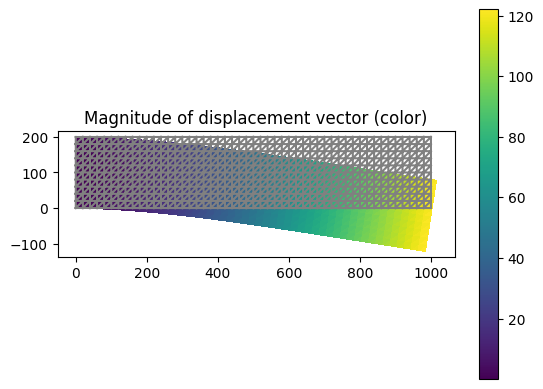

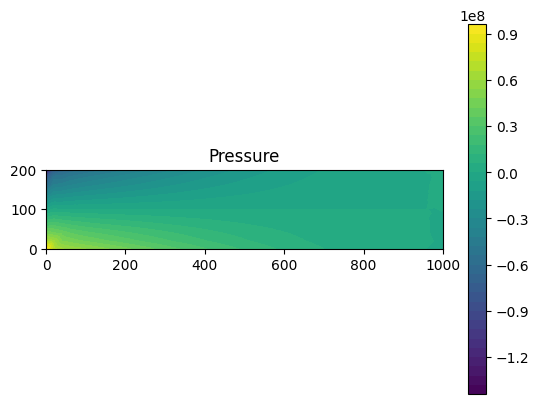

In [4]:
plt.figure()
h = plot(usol, mode='displacement', title='Magnitude of displacement vector (color)'); # Plot solution
plot(mesh); 
plt.colorbar(h);

# Calculate pressure field
plt.figure()
p = -tr(sig(usol))/2 # mean normal stress
h = plot(p, title='Pressure');
plt.colorbar(h);

In [5]:
# Potential energy contributions (elastic and gravitational) (see p. 136)
U_ela = assemble( 0.5*inner(sig(usol),eps(usol)) * dx ) # Integral over the elastic energy density
dU_pot = assemble( -dot(fvec,usol) * dx )               # Integral over the change in grav. potential energy density
print('U_ela =', U_ela)
print('dU_pot =', dU_pot)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
U_ela = 45082926556.63341
dU_pot = -90165853113.86359


In [6]:
def find_solution(Hw, mesh):
    deg = 1 # Polynomial degree 
    V   = VectorFunctionSpace(mesh, 'Lagrange', deg); # Polynomial function space of order "deg" (=1 is linear, ...)
    u   = TrialFunction(V) # the unknown function
    w   = TestFunction(V)  # the weight function 
    
    def lft_boundary(x, on_boundary): return on_boundary and near(x[0], 0) 
    
    
    fvec = rho*Constant ((0,-g0)) # Gravity force vector
    def eps(u): return sym(grad(u)) # strain -displacement relation
    def sig(u): return 2*mu*eps(u) + lam*tr(eps(u))* Identity (2)
    
    y = Expression('x[1]',degree =1) # y coordinate
    pw = conditional(le(y, Hw), rhow*g0*(Hw -y), 0) # Water pres. field
    sigw = -pw*Identity (2) # Water stress tensor for a fluid at rest

    n = FacetNormal(mesh)

    a = inner(sig(u), grad(w))*dx
    L = inner(fvec , w)*dx
    F = dot(dot(sigw ,n),w)*ds # Stress BC



    # Boundary conditions 
    bc  = [] # empty list of boundary conditions that we can append (add) to
    bc += [DirichletBC(V, Constant((0,0)), lft_boundary)] # u = 0 on lft_boundary
    # bc + [F]

    # Compute solution
    usol = Function(V)       # Define a new function in the space "V" with expansion coefs = 0.
    solve(a == L + F, usol, bc); # Solve the linear FEM problem (Ax=b) for the unknown expansion coef. vector (x) and stored it in "usol".
    return usol

In [14]:
# from tqdm.notebook import tqdm
def find_best_Hw(mesh, _eta = 5):
    maxN = 400

    eta = _eta

    

    # find start Hw
    low = 9999
    for start_hw in np.linspace(0,400,40):
        usol = find_solution(start_hw, mesh)
        s = usol.compute_vertex_values().max()
        if s < low:
            low = s
            Hw = start_hw
            
    print("Starting at",Hw)
    # Hw = 170
    last_Hw = Hw-0.1
    last_s = find_solution(last_Hw, mesh).compute_vertex_values().max()

    for i in (range(maxN)):

        usol = find_solution(Hw, mesh)
        s = usol.compute_vertex_values().max()

        _dy = (s - last_s) + 0.00001
        _dx = (Hw - last_Hw)*100 + 0.00001

        gradient = _dy/_dx*eta
        
#         if abs(gradient) > 0.05:
#             gradient = gradient/abs(gradient)*0.05
            
        print(gradient)
        if (abs(gradient) < 0.001) and s < 0.3:
            print(gradient)
            # print(f"Found optimal Hw: {Hw}")
            break
            # pass
        jump = - gradient*s*(maxN - i)/maxN

        # print(gradient)
        print(f"Loss: {s:.3}")
        # print(f"At water height {int(Hw)}m max displacement is {s:.3} m")

        last_s = s
        last_Hw = Hw

        Hw += jump
        
    return Hw


In [35]:
# help(usol)
best_Hw = find_best_Hw(mesh, 250)

print(best_Hw)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.


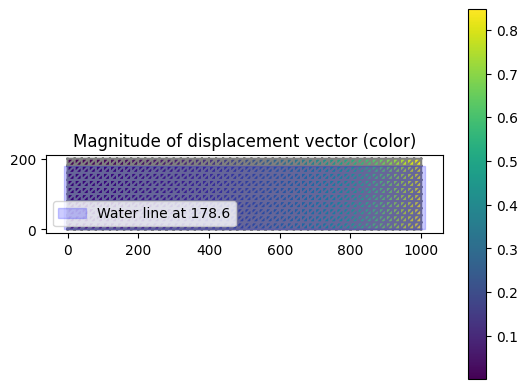

In [37]:
usol = find_solution(best_Hw, mesh)

plt.figure()
h = plot(usol, mode='displacement', title='Magnitude of displacement vector (color)'); # Plot solution
plot(mesh); 
plt.fill_between([-10,1010],[best_Hw,best_Hw],[0,0], color = "Blue", alpha = 0.2, label = f"Water line at {best_Hw:.4}")
plt.colorbar(h);
plt.legend(loc = "lower left");
plt.show()

# Calculate pressure field
# plt.figure()
# p = -tr(sig(usol))/2 # mean normal stress
# h = plot(p, title='Pressure');
# plt.colorbar(h);

In [34]:
rho/rhow*200

178.2312925170068

In [40]:
full_mesh = Mesh("ice_shapes/full.xml")

best_Hw_full = find_best_Hw(full_mesh, 500)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.


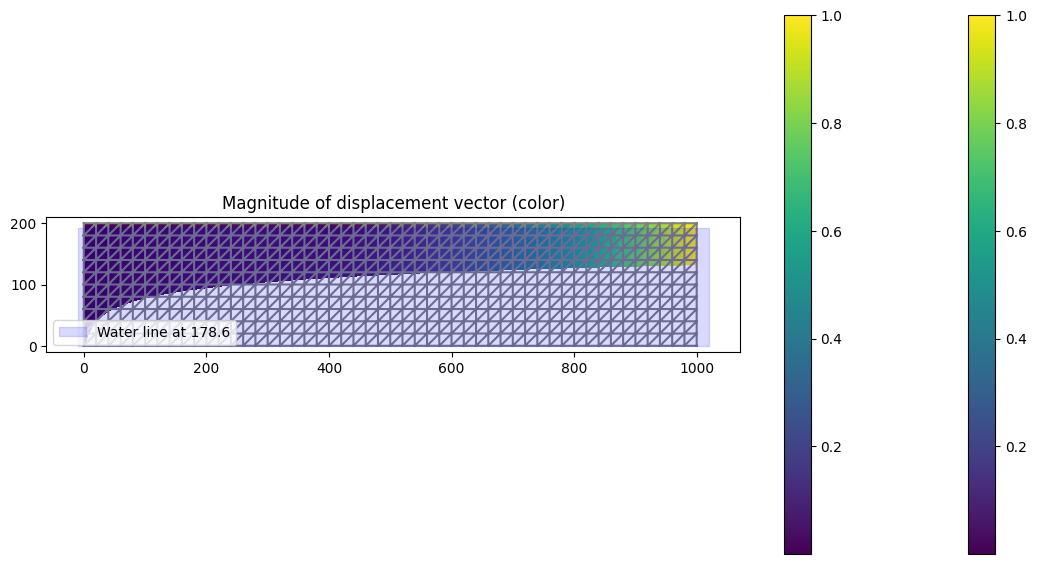

In [47]:
usol = find_solution(best_Hw_full, full_mesh)

plt.figure(figsize = (14,7))
h = plot(usol, mode='displacement', title='Magnitude of displacement vector (color)'); # Plot solution
plot(mesh); 
plt.fill_between([-10,1020],[best_Hw_full,best_Hw_full],[0,0], color = "Blue", alpha = 0.15, label = f"Water line at {best_Hw:.4}")
plt.colorbar(h);
plt.legend(loc = "lower left");
plt.colorbar(h);


In [48]:
usol_best = find_solution(best_Hw, mesh)
usol_full_best = find_solution(best_Hw_full, full_mesh)

before = (usol_best.compute_vertex_values().max(), usol_full_best.compute_vertex_values().max())

usol = find_solution(best_Hw+1, mesh)
usol_full = find_solution(best_Hw_full+1, full_mesh)

after = (usol.compute_vertex_values().max(), usol_full.compute_vertex_values().max())

Solving linear variational problem.
Solving linear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


In [49]:
print(f"max displacement for normal goes from {before[0]:.3} to {after[0]:.3}")
print(f"max displacement for full goes from {before[1]:.3} to {after[1]:.3}")


"worse"

max displacement for normal goes from 0.0232 to 0.102
max displacement for full goes from 0.0272 to 3.48


'worse'

Object cannot be plotted directly, projecting to piecewise linears.
  Calling FFC just-in-time (JIT) compiler, this may take some time.


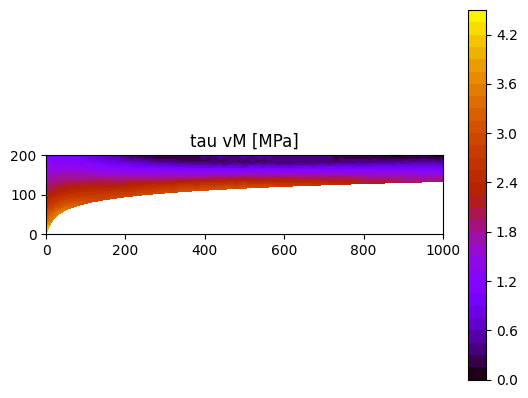

In [53]:
def plot_von_mises(usol):
    tau_vM = sqrt( 3/2* inner(tau(usol),tau(usol)) ) # von Mises
    plt.figure ()
    h = plot(tau_vM *1e-6, title='tau vM [MPa]', cmap='gnuplot')
    plt.colorbar(h)
    plt.show()
    
    
plot_von_mises(usol_full_best)

  Solving linear variational problem.
  Object cannot be plotted directly, projecting to piecewise linears.


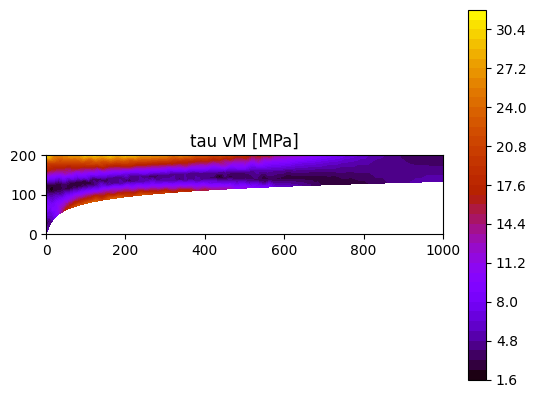

In [111]:
plot_von_mises(find_solution(best_Hw_full+100, full_mesh))

In [57]:
damaged_mesh = Mesh("ice_shapes/damaged.xml")

best_Hw_damaged = find_best_Hw(damaged_mesh, 1)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [58]:
best_Hw_damaged

191.9001058369927

    Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


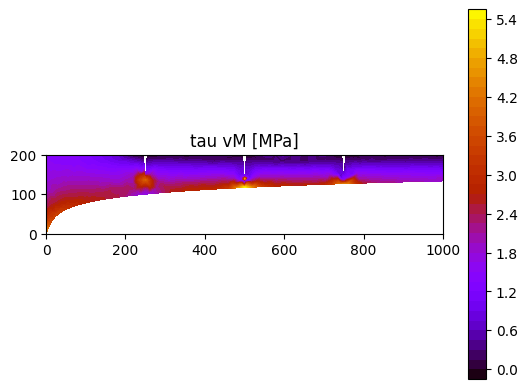

    Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


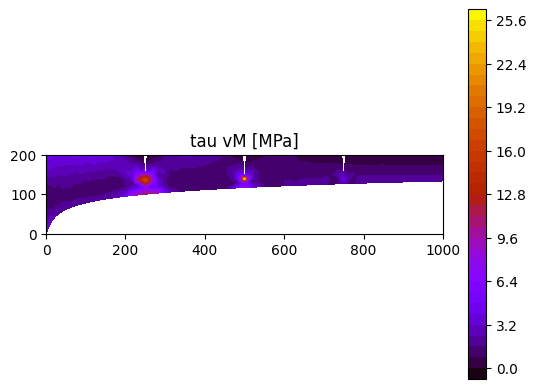

In [59]:
usol_damaged = find_solution(best_Hw_damaged, damaged_mesh)

plot_von_mises(usol_damaged)

usol_damaged = find_solution(best_Hw_damaged+1, damaged_mesh)

plot_von_mises(usol_damaged)

In [114]:
Which stress component τi j contributes the most to τvM?

Object `τvM` not found.


Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


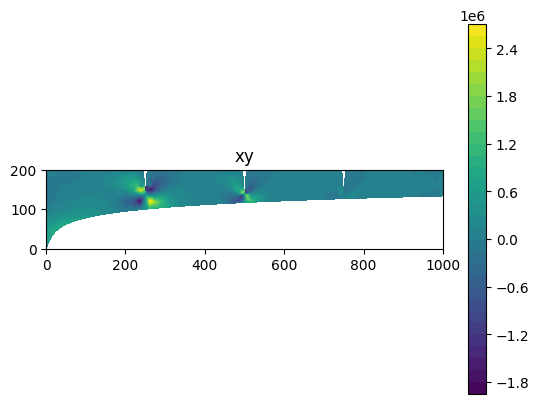

Object cannot be plotted directly, projecting to piecewise linears.


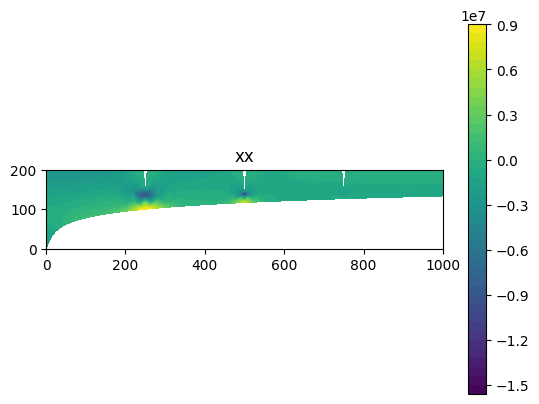

Object cannot be plotted directly, projecting to piecewise linears.


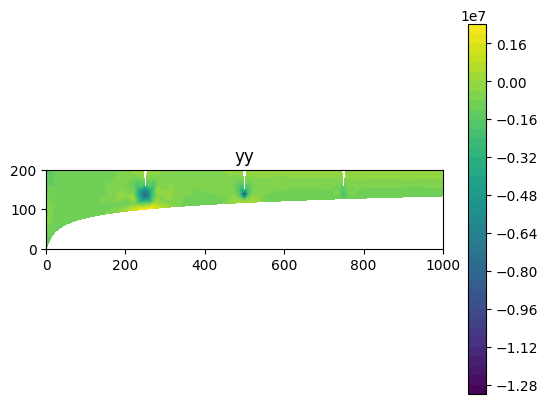

Object cannot be plotted directly, projecting to piecewise linears.


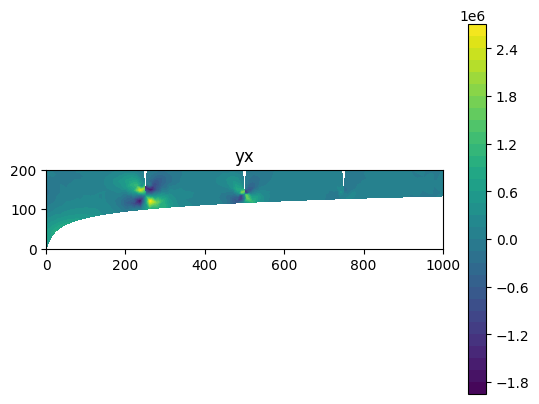

In [75]:
ex = Constant ((1 ,0)) # Constant vector on mesh
ey = Constant ((0 ,1)) # Constant vector on mesh

usol_damaged = find_solution(best_Hw_damaged+1, damaged_mesh)

names = ["xy","xx","yy","yx"]
i = 0
for eex, eey in [(ex,ey),(ex,ex),(ey,ey),(ey,ex)]:
    tau_xy = dot(dot(tau(usol_damaged), eex), eey)
    dir(tau_xy)
    h = plot(tau_xy)
    plt.title(names[i])
    plt.colorbar(h)

    i += 1
    plt.show()

  Solving linear variational problem.
  Object cannot be plotted directly, projecting to piecewise linears.


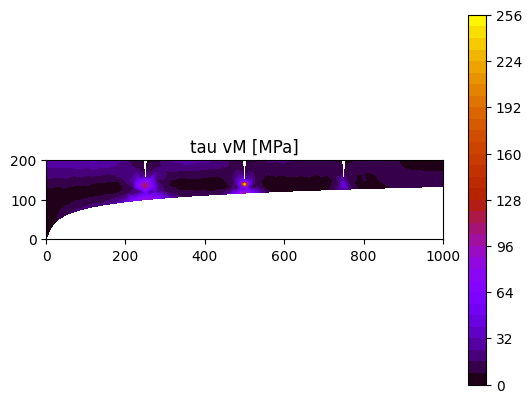

  Solving linear variational problem.
  Object cannot be plotted directly, projecting to piecewise linears.


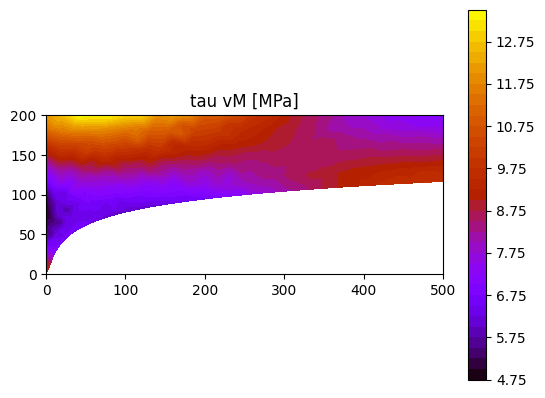

In [126]:
calved_mesh = Mesh("ice_shapes/calved.xml")


usol_damaged = find_solution(400, damaged_mesh)

plot_von_mises(usol_damaged)

usol_calved = find_solution(400, calved_mesh)

plot_von_mises(usol_calved)